In [2]:
# Run all setup-code
import numpy as np
import scipy as sp
import matplotlib.pyplot as mplot
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate as integrate
import matplotlib.animation as animation
import numpy.linalg as LA
import gplearn as gp
import scipy.optimize as opt
from mpl_toolkits import mplot3d
from scipy.optimize import fsolve
from matplotlib.pylab import time
from matplotlib.animation import FFMpegWriter
import sklearn.linear_model as sklm


## January 31, 2020: SINDy Lokta-Voltera

This work is directly motivated by that of Nathan Kutz and Kathleen Champion, who developed SINDy, which takes data from dynamical systems and reproduces the governing equations. We want to find $f(x)$ where  
$$
\dot{x}(t) = f(x(t))
$$
given $\dot{x}$ and $x$ at various time values. We take the data from one orbit and project onto a matrix that represents different possible functions. In general, we solve 
$$
\dot{x} = \Theta\xi
$$
where $\Theta$ is constructed as different possible terms in $f(x)$. For example, if it is believed that a constant function might appear in $f(x)$, then $\Theta$ will have a column of $1$s. If we have $x = [x_1, x_2]$ and we believe there is a term $x_1^2$ then we include a column that is $\bar{x_1}^2$ where $\bar{x_1}$ is the given information of $x_1$. \\

Once we have constructed $\Theta$ with appropriate guesses, we preform a least-squares regression to solve for $\xi$. $\xi$ then acts as the coefficients on the columns of $\Theta$ corresponding to their function values.

The first attempt at running SINDy was through data simulated from Lokta-Voltera. The original system was of the form 
$$
\begin{array}{c}
\dot{x_1} = ax + by\\
\dot{x_2} = cx + dy
\end{array}
$$
with various values for $a,b,c,d\in \mathbb{R}$. These simulations were run in Python and the data for $X = [x_1,x_2]$ and $\dot{X}$ were collected. In our experiments we use $a=2/3$, $b=-4/3$, $c=1$ and $d=-1$. 

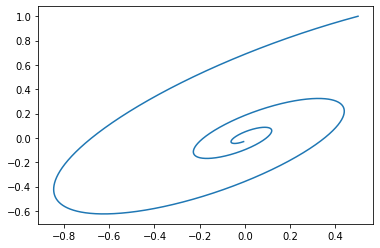

In [3]:
# Lokta-Voltera as proof of concept. 

#coefficients of Lokta-Voltera or modified model
a=2/3
b=-4/3
c=1
d=-1

#Time for dynamical system simulation
tstart=0 # start time
tstop=20 # end time
meshsize=100000
time=np.linspace(tstart,tstop,meshsize) # setting up time mesh
total_variables = 2 #dimention of the system

#Initial Values
IP=[.5,1]

# Lokta-Voltera Function
def LV(X,t):
    dXdt=[a*X[0]+b*X[1], c*X[0]+d*X[1]]
    return dXdt

# Solve the ODE
A=integrate.odeint(LV, IP, time) 

dXdt=np.empty([meshsize,2])

#Solve for dXdt
for i in range(meshsize):
    dXdt[i,:]=LV(A[i,:], time[i])

# Plot the trajectory for verification
mplot.plot(A[:,0],A[:,1])

Once we have constructed $\Theta$ with appropriate guesses, we preform a least-squares regression to solve for $\xi$. $\xi$ then acts as the coefficients on the columns of $\Theta$ corresponding to their function values. In this case we use the guesses $1$ $x$, $y$, $xy$, $x^2$, $y^2$, and $\sin(x)$. 

In [4]:
## List of Potential Functions
# Constant
One = np.ones([meshsize, 1]) 
# Linear
x = A[:,0]
y = A[:,1]
# Quadratic
xy = np.multiply(x,y)
x2 = x**2
y2 = y**2
# Nonlinear 
sinx = sp.sin(x)


# Actual answer for comparison of errors 
Actual = np.empty([7,2])
Actual[:,0] = np.transpose([0,a,b,0,0,0,0])
Actual[:,1] = np.transpose([0,c,d,0,0,0,0])



#Make a Theta Matrix
Theta = np.column_stack((One, x, y, xy, x2, y2, sinx))

#Solve for Coeffcients
Xi = LA.lstsq(Theta,dXdt, rcond = None)[0]

We then use SINDy as a tool to refine our regression. We input a threshold $\lambda$ and zero-out any components $\xi_{ij}<\lambda$. We then regress on the remaining components and repeat this process 1 to 10 times. A stopping condition can be added to achieve best results and efficiency.

In [5]:
l=.1 # Set the Threshold value 

condition = np.abs(Xi) > l # Set a condition for below threshold
Xi = np.where(condition, Xi, np.zeros(Xi.shape)) # Zero-out all elements below l

# Re-regress
for j in range(2):# 2 because that is the total number of variables
    vec = condition[:,j] # Extract first variable
    bigind = [i for i in range(len(vec)) if vec[i] == True] #Save the large values
    # Rerun the regression on the functions with components >l
    Xi[bigind, j] = LA.lstsq(Theta[:, bigind], dXdt[:,j], rcond = None)[0]

# Find the Error, both induced 2-norm and Frobenius
norm_error = LA.norm(Xi-Actual)
entry_error = np.amax(Xi-Actual)

print('Normal')
print('Coefficients                               Norm Error                 Entry Error')
print(Xi,'              ', norm_error,'                 ', entry_error)

Normal
Coefficients                               Norm Error                 Entry Error
[[ 0.          0.        ]
 [ 0.66666667  1.        ]
 [-1.33333333 -1.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]                1.3732700395566712e-14                   8.43769498715119e-15


Notice in this case, we got the exact results after one iteration of regression. However, we will notice when we add noise this will be necessary.

In the next code, we consider adding noise to $\dot{X}$ to see how the regression behaves. 

In [6]:
eta = 5 # Noise magnitude
Z = np.random.normal(0,eta,dXdt.size) # Create Noise Matrix
Z = np.reshape(Z, dXdt.shape)

dXdt_rand = dXdt - eta*Z # Add Noise to dXdt

We then re-run SINDy to see how well the regression has worked.

In [7]:
#Solve for Coeffcients
Xi_rand = LA.lstsq(Theta,dXdt_rand, rcond = None)[0]

l=.5

for k in range(1): # Number of times we re-regress
    condition = np.abs(Xi) > l
    Xi_rand = np.where(condition, Xi_rand, np.zeros(Xi.shape))

    for j in range(2):
        vec = condition[:,j]
        bigind = [i for i in range(len(vec)) if vec[i] == True]
        Xi_rand[bigind, j] = LA.lstsq(Theta[:, bigind], dXdt_rand[:,j], rcond = None)[0]
        
        
norm_error_rand = LA.norm(Xi_rand-Actual)
entry_error_rand = np.amax(Xi_rand-Actual)

print('                ')
print('Noise')
print('Coefficients                               Norm Error                 Entry Error')
print(Xi_rand,'     ', norm_error_rand,'        ', entry_error_rand)

                
Noise
Coefficients                               Norm Error                 Entry Error
[[ 0.          0.        ]
 [ 0.84231326  1.19363076]
 [-1.40555397 -1.35785336]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]       0.44902053786405405          0.19363075622113324


Another common sparse regression tool we consider is LASSO to see how it compares. LASSO seeks to minimize 
$$
||x-A\bar{x}||_2+||x||_1
$$
when searching for $x=A\bar{x}$. However, we notice that this does not work well in our case, primarily because it seems to arbitrarily minimize components of $\xi$ instead of those that contribute significantly.

In [8]:
LSO = sklm.Lasso(alpha=10, max_iter=10000) # Set up the LASSO
LSO.fit(Theta, dXdt) # Train the network 
Xi_Lasso = np.transpose(np.vstack((LSO.coef_[0][:],LSO.coef_[1][:]))) # Extract the coefficients 

norm_error_Lasso = LA.norm(Xi_Lasso-Actual)
entry_error_Lasso = np.amax(Xi_Lasso-Actual)


print('                ')
print('Lasso')
print('Coefficients                               Norm Error                 Entry Error')
print(Xi_Lasso,'     ', norm_error_Lasso,'        ', entry_error_Lasso)

                
Lasso
Coefficients                               Norm Error                 Entry Error
[[ 0.  0.]
 [-0.  0.]
 [-0. -0.]
 [ 0. -0.]
 [ 0. -0.]
 [-0. -0.]
 [-0.  0.]]       2.0548046676563256          1.3333333333333333


Clearly this does not work well. We even consider sparse data to see if LASSO out-preforms SINDy.

In [9]:
dXdt_sparse = np.empty([round(meshsize/10),2])
Theta_sparse = np.empty([round(meshsize/10),7])

for i in range(round(meshsize/10)):
    dXdt_sparse[i,:] = dXdt[10*i,:]
    Theta_sparse[i,:] = Theta[10*i,:]

    
#Solve for Coeffcients
Xi = LA.lstsq(Theta_sparse,dXdt_sparse, rcond = None)[0]

l=.5

condition = np.abs(Xi) > l
Xi_sparse = np.where(condition, Xi, np.zeros(Xi.shape))

for j in range(total_variables):
    vec = condition[:,j]
    bigind = [i for i in range(len(vec)) if vec[i] == True]
    Xi[bigind, j] = LA.lstsq(Theta_sparse[:, bigind], dXdt_sparse[:,j], rcond = None)[0]
    
norm_error_sparse = LA.norm(Xi_sparse-Actual)
entry_error_sparse = np.amax(Xi_sparse-Actual)


print('                ')
print('Sparse') 
print('Coefficients                                  Norm Error                 Entry Error')
print(Xi_sparse,'                  ', norm_error_sparse,'           ', entry_error_sparse)



## Sparse and Noise

eta = 1 # Noise magnitude
Z = np.random.normal(0,eta,dXdt_sparse.size)
Z = np.reshape(Z, dXdt_sparse.shape)

dXdt_rand_sparse = dXdt_sparse - eta*Z 

#Solve for Coeffcients
Xi_sparse_rand = LA.lstsq(Theta_sparse,dXdt_rand_sparse, rcond = None)[0]

l=.5

for k in range(25):
    condition = np.abs(Xi) > l
    Xi_sparse_rand = np.where(condition, Xi, np.zeros(Xi.shape))

    for j in range(total_variables):
        vec = condition[:,j]
        bigind = [i for i in range(len(vec)) if vec[i] == True]
        Xi[bigind, j] = LA.lstsq(Theta_sparse[:, bigind], dXdt_rand_sparse[:,j], rcond = None)[0]
        
    
norm_error_sparse_rand = LA.norm(Xi_sparse-Actual)
entry_error_sparse_rand = np.amax(Xi_sparse-Actual)


print('                ')
print('Sparse and Random')
print('Coefficients                               Norm Error                 Entry Error')
print(Xi_sparse_rand,'               ', norm_error_sparse_rand,'        ', entry_error_sparse_rand)

## Trying Lasso on Sparse Data? Hopefully this makes things a litle better


LSO = sklm.Lasso(alpha=0.01, max_iter=10000)
LSO.fit(Theta_sparse, dXdt_sparse)
Xi_Lasso_sparse = np.transpose(np.vstack((LSO.coef_[0][:],LSO.coef_[1][:])))

norm_error_Lasso_sparse = LA.norm(Xi_Lasso-Actual)
entry_error_Lasso_sparse = np.amax(Xi_Lasso-Actual)


print('                ')
print('Lasso and Sparse')
print('Coefficients                               Norm Error                 Entry Error')
print(Xi_Lasso_sparse,'           ', norm_error_Lasso_sparse,'        ', entry_error_Lasso_sparse)

                
Sparse
Coefficients                                  Norm Error                 Entry Error
[[ 0.          0.        ]
 [ 0.66666667  1.        ]
 [-1.33333333 -1.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]                    6.899480070949581e-15             4.551914400963142e-15
                
Sparse and Random
Coefficients                               Norm Error                 Entry Error
[[ 0.          0.        ]
 [ 0.72837419  1.01227754]
 [-1.3442761  -1.01247894]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]                 6.899480070949581e-15          4.551914400963142e-15
                
Lasso and Sparse
Coefficients                               Norm Error                 Entry Error
[[ 0.          0.        ]
 [ 0.37641166  0.70974279]
 [-1.01046099 -0.67712618]
 [-0.         -0.        ]
 [-0.         -0.        ]

## Feburary 2, 2020: Lorenz System

We now consider the Lorenz System with variables $x,y,z$ given below:
$$
\begin{array}
\dot{x} = \sigma(y-x)\\
\dot{y} = x(\alpha-z)-y\\
\dot{z} = xy-\beta z
\end{array}
$$
with $\sigma = 10$, $alpha = 28$ and $\beta = 8/3$. We run the simulation for a single orbit with initial conditions $[10,1,2]$. 

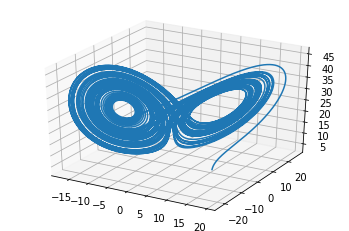

In [12]:
# Define the coefficients 
sigma = 10
alpha = 28
beta = 8/3

#Time for dynamical system simulation
tstart=0 # start time
tstop=60 # end time
meshsize=1000000
time=np.linspace(tstart,tstop,meshsize) # setting up time mesh

#Initial Values
IP=[10,1,2]

total_variables = 3

# Lorenz Attractor Equation
def Lor(X,t):
    dXdt=[sigma*(X[1]-X[0]), X[0]*(alpha-X[2])- X[1], X[0]*X[1]-beta*X[2]]
    return dXdt

# Simulate the trajectory
A=integrate.odeint(Lor, IP, time)


# Find dXdt
dXdt=np.empty([meshsize,total_variables])

for i in range(meshsize):
    dXdt[i,:]=Lor(A[i,:], time[i])
    
ax = mplot.axes(projection = '3d')
ax.plot(A[:,0], A[:,1], A[:,2])

We then return to using SINDy. Here we consider considerably more guesses. To be able to do this efficiently, we define all the polynomial guesses in a loop. From this we run SINDy as a regression and have the results below. 

In [13]:
i=0
total_guesses = 1 + total_variables + total_variables**2

Actual = np.zeros([total_guesses, total_variables])
Actual[1,:] = [-10, 28, 0]
Actual[2,:] = [10, -1, 0]
Actual[3,:] = [0, 0, -8/3]
Actual[5,2] = 1
Actual[6,1] = -1

Theta = np.empty([meshsize,total_guesses])
Theta[:,0] = np.ones(meshsize)
i = i+1

for j in range(total_variables):
    Theta[:,i] = A[:, j]
    i = i+1

 # Uncomment if quadratic terms are desired 
for j in range(total_variables):
    for l in range(total_variables-j):
        Theta[:,i] = A[:,j]*A[:,l+j]
        i = i+1

#Solve for Coeffcients
Xi = LA.lstsq(Theta,dXdt, rcond = None)[0]

l=.5

condition = np.abs(Xi) > l
Xi = np.where(condition, Xi, np.zeros(Xi.shape))

for j in range(total_variables):
    vec = condition[:,j]
    bigind = [i for i in range(len(vec)) if vec[i] == True]
    Xi[bigind, j] = LA.lstsq(Theta[:, bigind], dXdt[:,j], rcond = None)[0]
    
norm_error = LA.norm(Xi-Actual)
entry_error = np.amax(abs(Xi-Actual))

print('Normal')
print('Coefficients                                        Norm Error                    Entry Error')
print(Xi,'         ', norm_error,'            ', entry_error)


Normal
Coefficients                                        Norm Error                    Entry Error
[[  0.           0.           0.        ]
 [-10.          28.           0.        ]
 [ 10.          -1.           0.        ]
 [  0.           0.          -2.66666667]
 [  0.           0.           0.        ]
 [  0.           0.           1.        ]
 [  0.          -1.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]           4.5043270979806086e-13              2.9309887850104133e-13


We then proceed with the same simulations as the Lotka-Volterra simulations with added noise and LASSO comparisons.

In [16]:
eta = 1 # Noise magnitude
Z = np.random.normal(0,eta,dXdt.size)
Z = np.reshape(Z, dXdt.shape)

Random_dXdt = dXdt - eta*Z 

#Solve for Coeffcients
Xi_rand = LA.lstsq(Theta,Random_dXdt, rcond = None)[0]

l=.5

for k in range(10):
    condition = np.abs(Xi) > l
    Xi_rand = np.where(condition, Xi, np.zeros(Xi.shape))

    for j in range(total_variables):
        vec = condition[:,j]
        bigind = [i for i in range(len(vec)) if vec[i] == True]
        Xi_rand[bigind, j] = LA.lstsq(Theta[:, bigind], Random_dXdt[:,j], rcond = None)[0]

norm_error_rand = LA.norm(Xi_rand-Actual)
entry_error_rand = np.amax(Xi_rand-Actual)

print('                ')
print('Noise')
print('Coefficients                               Norm Error                 Entry Error')
print(Xi_rand,'     ', norm_error_rand,'        ', entry_error_rand)


#%% Trying Lasso

LSO = sklm.Lasso(alpha=1, max_iter=5000, warm_start='True', selection='random')
LSO.fit(Theta, dXdt)
Xi_Lasso = np.transpose(np.vstack((LSO.coef_[0][:],LSO.coef_[1][:], LSO.coef_[2])))

norm_error_Lasso = LA.norm(Xi_Lasso-Actual)
entry_error_Lasso = np.amax(Xi_Lasso-Actual)


print('                ')
print('Lasso')
print('Coefficients                               Norm Error                 Entry Error')
print(Xi_Lasso,'     ', norm_error_Lasso,'        ', entry_error_Lasso)

#%% Working with sparser data

dXdt_sparse = np.empty([round(meshsize/10),3])
Theta_sparse = np.empty([round(meshsize/10),total_guesses])

for i in range(round(meshsize/10)):
    dXdt_sparse[i,:] = dXdt[10*i,:]
    Theta_sparse[i,:] = Theta[10*i,:]

    
#Solve for Coeffcients
Xi_sparse = LA.lstsq(Theta_sparse,dXdt_sparse, rcond = None)[0]

l=.5

condition = np.abs(Xi) > l
Xi_sparse = np.where(condition, Xi, np.zeros(Xi.shape))

for j in range(total_variables):
    vec = condition[:,j]
    bigind = [i for i in range(len(vec)) if vec[i] == True]
    Xi_sparse[bigind, j] = LA.lstsq(Theta_sparse[:, bigind], dXdt_sparse[:,j], rcond = None)[0]


norm_error_sparse = LA.norm(Xi_sparse-Actual)
entry_error_sparse = np.amax(Xi_sparse-Actual)


print('                ')
print('Sparse')
print('Coefficients                   Norm Error                 Entry Error')
print(Xi_sparse,'       ', norm_error_sparse,'             ', entry_error_sparse)



## Sparse and Noise

eta = 1 # Noise magnitude
Z = np.random.normal(0,eta,dXdt_sparse.size)
Z = np.reshape(Z, dXdt_sparse.shape)

dXdt_rand_sparse = dXdt_sparse - eta*Z 

#Solve for Coeffcients
Xi_sparse_rand = LA.lstsq(Theta_sparse,dXdt_rand_sparse, rcond = None)[0]

l=.5

for k in range(10):
    condition = np.abs(Xi) > l
    Xi_sparse_rand = np.where(condition, Xi, np.zeros(Xi.shape))

    for j in range(total_variables):
        vec = condition[:,j]
        bigind = [i for i in range(len(vec)) if vec[i] == True]
        Xi_sparse_rand[bigind, j] = LA.lstsq(Theta_sparse[:, bigind], dXdt_rand_sparse[:,j], rcond = None)[0]
        
    
norm_error_sparse_rand = LA.norm(Xi_sparse-Actual)
entry_error_sparse_rand = np.amax(Xi_sparse-Actual)


print('                ')
print('Sparse and Random')
print('Coefficients                               Norm Error                 Entry Error')
print(Xi_sparse_rand,'      ', norm_error_sparse_rand,'                ', entry_error_sparse_rand)

                
Noise
Coefficients                               Norm Error                 Entry Error
[[ 0.          0.          0.        ]
 [-9.99991017 28.00130242  0.        ]
 [ 9.99992393 -1.00068382  0.        ]
 [ 0.          0.         -2.66667204]
 [ 0.          0.          0.        ]
 [ 0.          0.          1.00000606]
 [ 0.         -1.00001933  0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]       0.001475872574956473          0.0013024208422471872
                
Lasso
Coefficients                               Norm Error                 Entry Error
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.60114554e+00  2.59638228e+01  0.00000000e+00]
 [ 6.52486799e+00  1.26647165e-01  0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+00 -4.98412884e-01]
 [-4.20211694e-03  0